# Data Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display # Allows the use of display() for DataFrames
%matplotlib inline

# Import our raw data into a Pandas Dataframe
# low_memory is just to make the 'mixed types' warning go away.
df1 = pd.read_csv('delta_public_87_99.csv', low_memory=False)
df2 = pd.read_csv('delta_public_00_12.csv', low_memory=False)

# Combine the 87-99 data with the 00-12 data into one frame
frames = [df1, df2]
data = pd.concat(frames)


## Data Exploration

In [2]:
# Get number of observations and number of attributes
print data.shape

(215613, 974)


In [3]:
# Get some summary statistics of our target variable
display(data['total_enrollment'].describe())

count    153168.000000
mean       2809.486148
std        7540.511589
min           0.000000
25%         101.000000
50%         481.000000
75%        2344.000000
max      380232.000000
Name: total_enrollment, dtype: float64

In [4]:
# Drop rows with missing enrollment data
data = data[np.isfinite(data['total_enrollment'])]
data.shape

(153168, 974)

,total_enrollment,totalcompletions,assets06,loan_num,fte_count
count,153168.000000,139169.000000,6.296600e+04,68345.000000,151361.000000
mean,2809.486148,593.236129,1.798120e+08,240.711777,2112.358154
std,7540.511589,1456.242667,1.134594e+09,747.546118,5771.201134
min,0.000000,0.000000,-3.721908e+06,0.000000,0.000000
25%,101.000000,56.000000,1.868081e+06,15.000000,87.909080
50%,481.000000,189.000000,1.912804e+07,82.000000,424.714240
75%,2344.000000,544.000000,8.559663e+07,262.000000,1818.719801
max,380232.000000,92011.000000,6.410306e+10,106840.000000,380232.000000


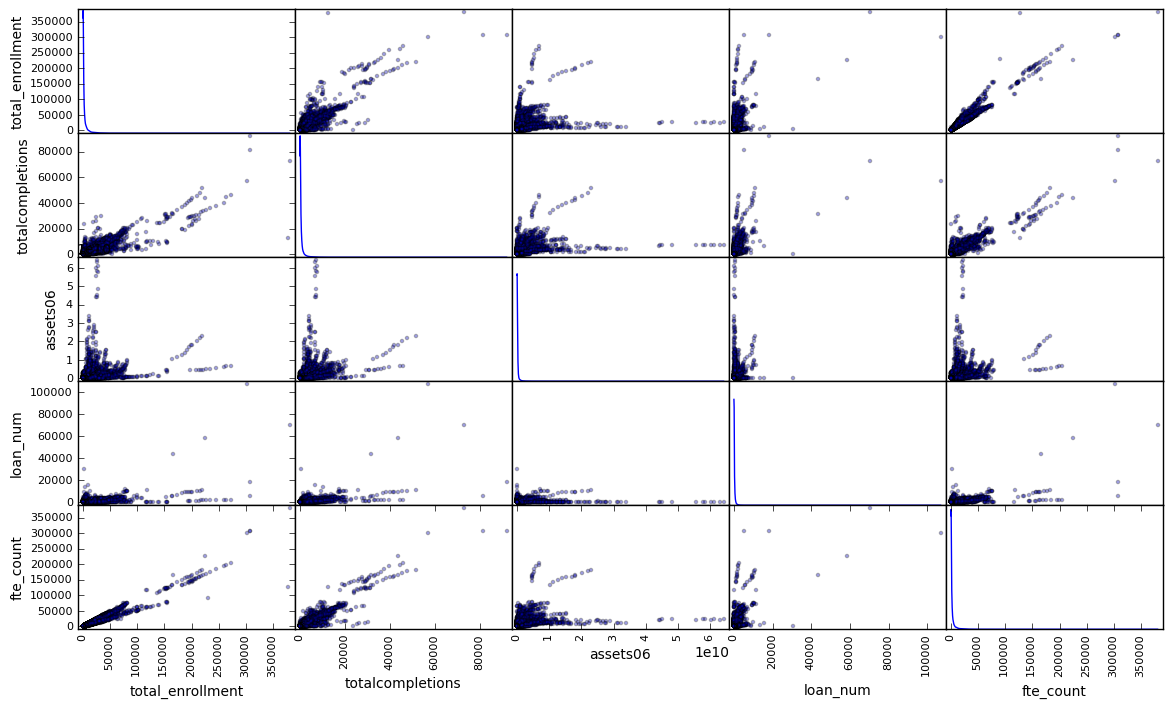

In [5]:
# Produce a scatter matrix for several sample pairs of features in the data
sample_cols = ['total_enrollment', 'totalcompletions', 'assets06', 'loan_num', 'fte_count']
display(data[sample_cols].describe())
pd.scatter_matrix(data[sample_cols], alpha = 0.3, figsize = (14,8), diagonal = 'kde');


## Data Preprocessing

In [6]:
# Drop non-numbers, not useful for us
data = data.select_dtypes(include=['float64', 'int64'])

# Force the numeric cells to be proper numbers
data = data.convert_objects(convert_numeric=True)

# Impute missing data via interpolation
data = data.interpolate()

# Use mean for remaining missing data
data = data.fillna(data.mean())

display(data[sample_cols].describe())

,total_enrollment,totalcompletions,assets06,loan_num,fte_count
count,153168.000000,153168.000000,1.531680e+05,153168.000000,153168.000000
mean,2809.486148,556.438127,1.365838e+08,231.636307,2095.916510
std,7540.511589,1399.547138,8.299817e+08,506.763413,5741.356536
min,0.000000,0.000000,-3.721908e+06,0.000000,0.000000
25%,101.000000,52.000000,3.062782e+06,80.000000,87.349826
50%,481.000000,171.000000,1.853206e+07,231.636307,419.811810
75%,2344.000000,503.000000,6.882778e+07,231.636307,1800.892742
max,380232.000000,92011.000000,6.410306e+10,106840.000000,380232.000000


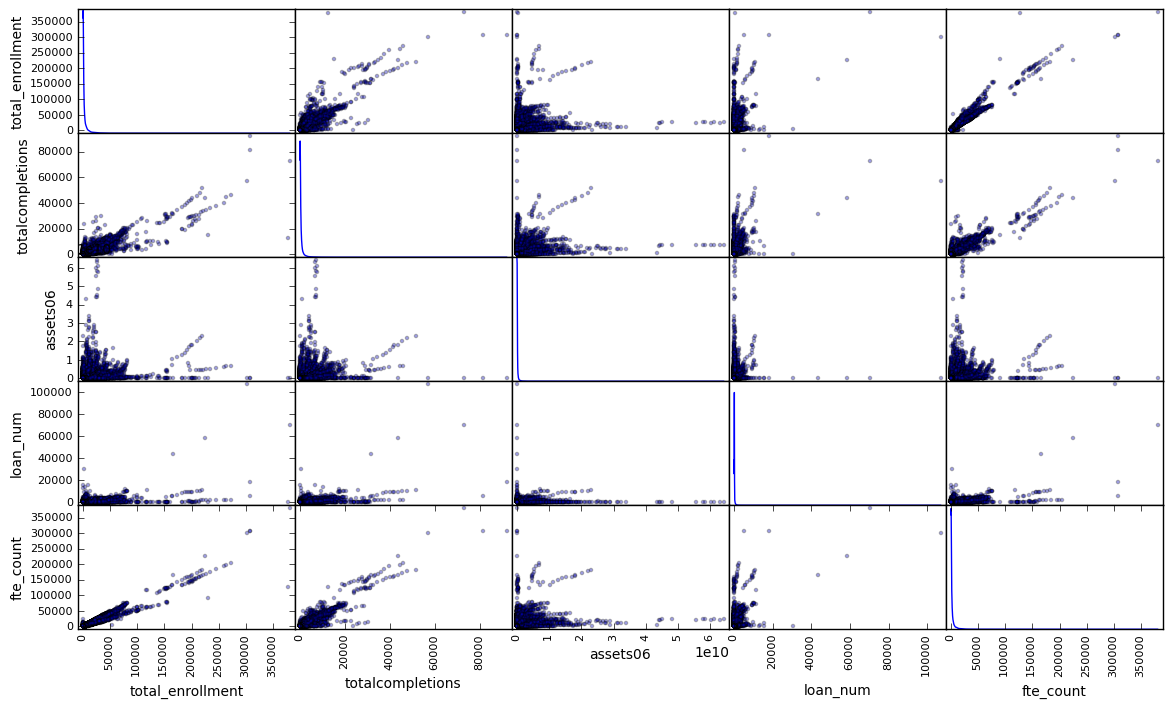

In [7]:
# Produce a scatter matrix for several sample pairs of features in the data
pd.scatter_matrix(data[sample_cols], alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [8]:
# Normalize all floating point columns
float64_columns = list(data.select_dtypes(include=['float64']).columns)

#data[float64_columns] = np.log(data[float64_columns])

# min/max scale, and multiply by 10k to avoid tiny numbers.  Then take the log to center.
data = 10000*(data - data.min()) / (data.max() - data.min())
data = np.log(data)

# the log(0) values were turned into -inf, we want those as zero for normalization
data = data.replace(-np.inf, 0)

display(data[sample_cols].describe())

,total_enrollment,totalcompletions,assets06,loan_num,fte_count
count,153168.000000,153168.000000,153168.000000,153168.000000,153168.000000
mean,2.541128,2.853081,1.428971,2.477814,2.348934
std,2.054605,1.661987,1.545059,1.321536,1.982079
min,-3.638196,-3.828761,-2.306099,-4.630510,-4.729624
25%,0.976924,1.731921,0.056704,2.013279,0.831725
50%,2.537671,2.922341,1.244555,3.076421,2.401610
75%,4.121418,4.001267,2.426307,3.076421,3.857841
max,9.210340,9.210340,9.210340,9.210340,9.210340


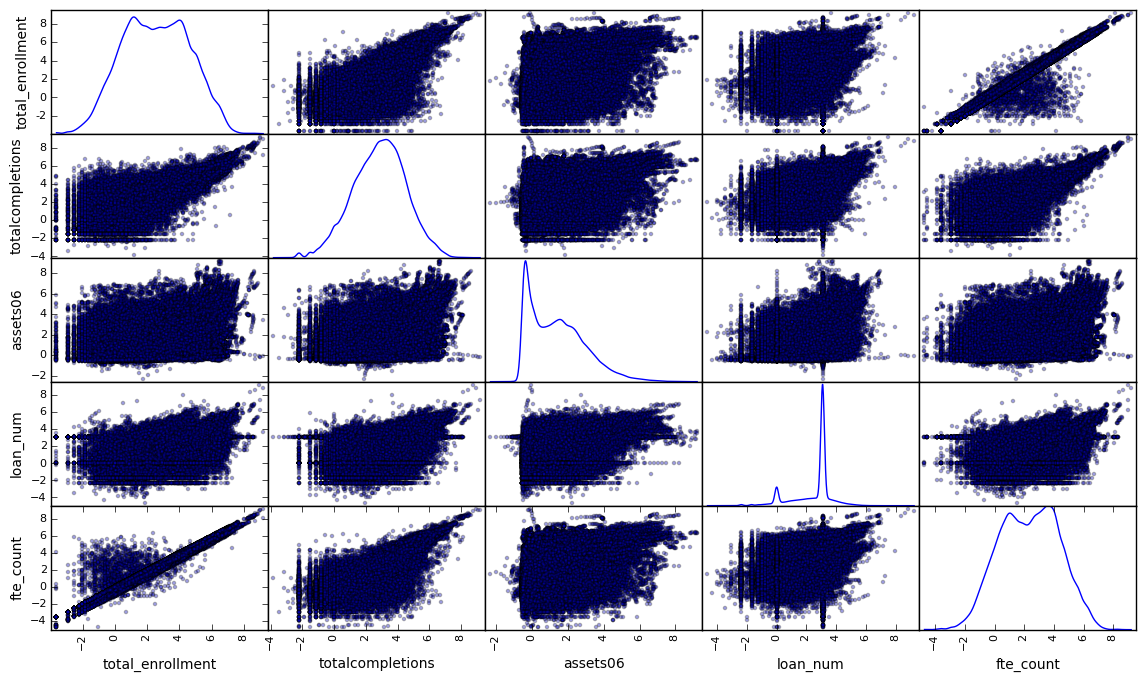

In [9]:
# Produce a scatter matrix for several normalized sample pairs of features in the data
pd.scatter_matrix(data[sample_cols], alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [10]:
# Isolate Target Variable
enrollment = data['total_enrollment']
features = data.drop('total_enrollment', axis = 1)

In [11]:
from sklearn.cross_validation import train_test_split

# Split to training data and testing data
X_train, X_test, y_train, y_test = train_test_split(features, enrollment, test_size=0.2, random_state=42)

## Baseline and Candidate Models

In [18]:
# Baseline Model
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

# Use admission's count, plus the retention data in a linear regression
reg.fit(X_train[['admitcount', 'ptretention_rate', 'ftretention_rate']], y_train)

from sklearn.metrics import mean_squared_error

baseline_pred = reg.predict(X_test[['admitcount', 'ptretention_rate', 'ftretention_rate']])

# Turns out this is a terrible way to predict.  Hopefully we can do better than that.
print mean_squared_error(y_test, baseline_pred)

4.08769180559


In [21]:
from sklearn.decomposition import FastICA

# n_components = 17, because that's the max number of features with
# the number of observations we have, considering the curse of
# dimensionality
ica = FastICA(n_components=17, random_state=42)
ica.fit(X_train)

# Our new 17 features
X_train_ica = ica.transform(X_train)
X_test_ica = ica.transform(X_test)

In [23]:
# Candidate Model 1, Linear Regression
# Same technique as the baseline, but uses our ICA features instead of the three preset

cm1_reg = LinearRegression()

# Make sure to use the ICA features
cm1_reg.fit(X_train_ica, y_train)

# Generate predictions
cm1_pred = cm1_reg.predict(X_test_ica)

# Report Results
print "Candidate Model 1, Mean Squared Error:", mean_squared_error(y_test, cm1_pred)

Candidate Model 1, Mean Squared Error: 0.599484276357


In [24]:
# Candidate Model 2, Support Vector Regressor
# Notice: This model runs significantly slower than the baseline and candidate model 1 and 3
from sklearn.svm import SVR

cm2_reg = SVR()

# Make sure to use the ICA features
cm2_reg.fit(X_train_ica, y_train)

# Generate predictions
cm2_pred = cm2_reg.predict(X_test_ica)

# Report Results
print "Candidate Model 2, Mean Squared Error:", mean_squared_error(y_test, cm2_pred)

Candidate Model 2, Mean Squared Error: 3.8841817497


In [25]:
# Candidate Model 3, Random Forest Regressor (ensemble method)
from sklearn.ensemble import RandomForestRegressor

cm3_reg = RandomForestRegressor()

# Make sure to use the ICA features
cm3_reg.fit(X_train_ica, y_train)

# Generate predictions
cm3_pred = cm3_reg.predict(X_test_ica)

# Report Results
print "Candidate Model 3, Mean Squared Error:", mean_squared_error(y_test, cm3_pred)

Candidate Model 3, Mean Squared Error: 0.4050671602


In [ ]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Create the parameters list you wish to tune
parameters = {
    'criterion': ["mse", "mae"],
    'max_features': ["auto", "sqrt", "log2"],
}

# Initialize the classifier
fin_reg = RandomForestRegressor(random_state=42)

# Make an mean squared error scoring function using 'make_scorer' 
mse_scorer = make_scorer(mean_squared_error)

# Perform grid search on the model using the mse_scorer as the scoring method
grid_obj = GridSearchCV(fin_reg, parameters, scoring=mse_scorer)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train_ica, y_train)

# Get the estimator
fin_reg = grid_obj.best_estimator_

# Report the final mean squared error for training and testing after parameter tuning
print "Tuned model has a training MSE of: ", mean_squared_error(y_train, fin_reg.predict(X_train_ica))
print "Tuned model has a testing MSE score of:", mean_squared_error(fin_reg.predict(y_test, X_test_ica))

## Grid Search Parameters for Final Model